In [9]:
from pathlib import Path

import pymc as pm
import pymc_bart as pmb

import pandas as pd
import matplotlib.pyplot as pp
import arviz as az
import seaborn as sb

In [17]:
pp.style.available#use('arviz')

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'arviz-bluish',
 'arviz-brownish',
 'arviz-colors',
 'arviz-cyanish',
 'arviz-darkgrid',
 'arviz-doc',
 'arviz-docgrid',
 'arviz-grayscale',
 'arviz-greenish',
 'arviz-orangish',
 'arviz-plasmish',
 'arviz-purplish',
 'arviz-redish',
 'arviz-royish',
 'arviz-viridish',
 'arviz-white',
 'arviz-whitegrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [19]:
pp.style.use('arviz-whitegrid')

#### Chlorophyll prediction

In [10]:
data_dir = Path.cwd() / 'data' / 'reduced_columns'

In [11]:
df_chl = pd.read_parquet(
    data_dir / 'df_chl.pqt')

In [ ]:
df_chl.head()

,chl,hplc_flag
0,0.091,0
1,0.118,1
2,NaN,-1
3,0.614,1
4,0.158,1


[]

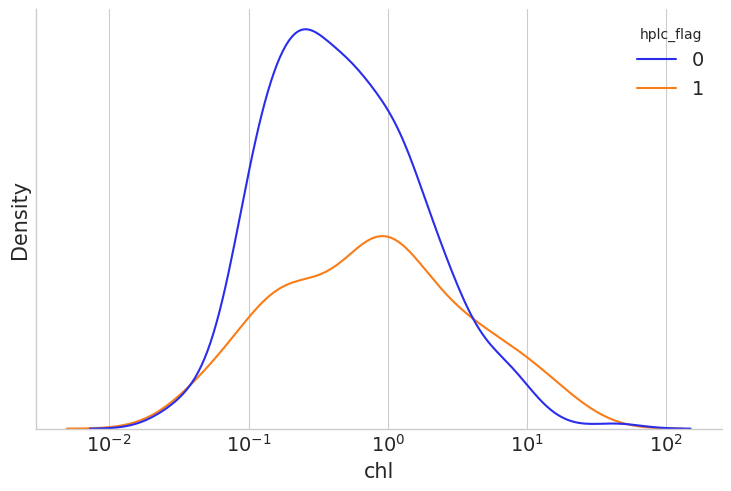

In [47]:
_, ax = pp.subplots()
sb.kdeplot(df_chl.dropna(), x='chl', hue='hplc_flag', log_scale=True, ax=ax);
ax.set_yticks([])

In [48]:
ax.get_xlim()

(0.0029561901792168185, 249.12662321082624)

In [22]:
df_in = pd.read_parquet(data_dir/'df_in_toa_radiance.pqt')

In [24]:
df_in.describe()

,Rrc_412,Rrc_443,Rrc_490,Rrc_510,Rrc_555,Rrc_670
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000
mean,0.006742,0.007025,0.007243,0.006734,0.006170,0.003537
std,0.003876,0.003640,0.003453,0.003350,0.003526,0.002458
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.003706,0.004168,0.004514,0.004123,0.003430,0.001666
50%,0.005988,0.006625,0.006866,0.005819,0.005138,0.002724
75%,0.008865,0.008941,0.009144,0.008748,0.007997,0.004723
max,0.020979,0.020130,0.018906,0.018512,0.019804,0.011320


In [25]:
import numpy as np

In [26]:
df_chl['log_chl'] = np.log10(df_chl.chl)

In [27]:
df_ = pd.merge(df_in, df_chl, left_index=True, right_index=True).dropna()

In [28]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424 entries, 0 to 494
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Rrc_412    424 non-null    float64
 1   Rrc_443    424 non-null    float64
 2   Rrc_490    424 non-null    float64
 3   Rrc_510    424 non-null    float64
 4   Rrc_555    424 non-null    float64
 5   Rrc_670    424 non-null    float64
 6   chl        424 non-null    float64
 7   hplc_flag  424 non-null    object 
 8   log_chl    424 non-null    float64
dtypes: float64(8), object(1)
memory usage: 33.1+ KB


In [29]:
X = df_.filter(regex='Rrc_[0-9]+')
Y = df_.log_chl

In [30]:
X

,Rrc_412,Rrc_443,Rrc_490,Rrc_510,Rrc_555,Rrc_670
0,0.012088,0.012417,0.011739,0.010579,0.009110,0.006655
1,0.010525,0.010636,0.009614,0.007913,0.006224,0.004794
3,0.005869,0.005866,0.005535,0.004643,0.003326,0.001747
4,0.009464,0.008968,0.007719,0.005974,0.004161,0.002517
5,0.001528,0.001902,0.002354,0.002507,0.002601,0.001331
...,...,...,...,...,...,...
490,0.003471,0.004862,0.007302,0.008243,0.009551,0.002989
491,0.004515,0.005307,0.006730,0.006899,0.006823,0.002647
492,0.006602,0.006798,0.006835,0.006987,0.007738,0.004951
493,0.010383,0.012110,0.014746,0.013465,0.011110,0.004133


In [31]:
with pm.Model() as m_chl_1:
    σ = pm.Exponential('σ', 1)
    μ = pmb.BART('μ', X=X, Y=Y)
    pm.Normal('likelihood', mu=μ, sigma=σ, observed=Y)
    

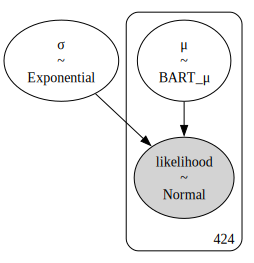

In [32]:
m_chl_1.to_graphviz()

In [33]:
with m_chl_1:
    idata_1 = pm.sample_prior_predictive()

Sampling: [likelihood, μ, σ]


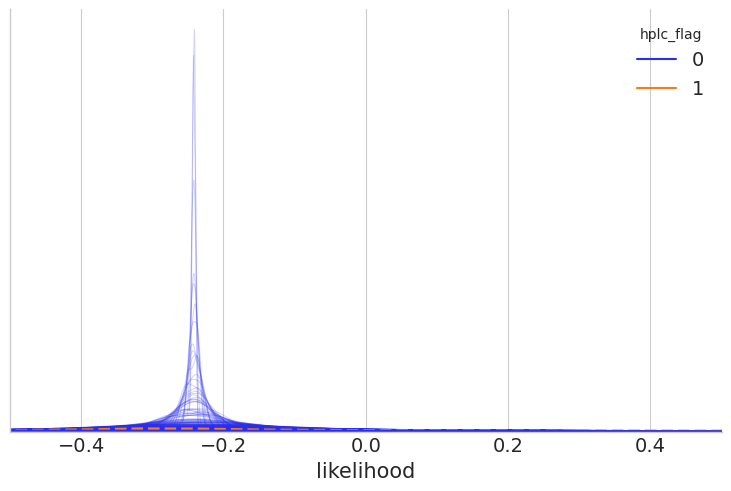

In [ ]:
_, ax=pp.subplots()
az.plot_ppc(idata_1, group='prior', ax=ax)
ax.set_xlim(-0.5, 0.5)
#ax.set_yticks([])

In [53]:
with m_chl_1:
    idata_1.extend(pm.sample())
    idata_1.extend(pm.sample_posterior_predictive(idata_1))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

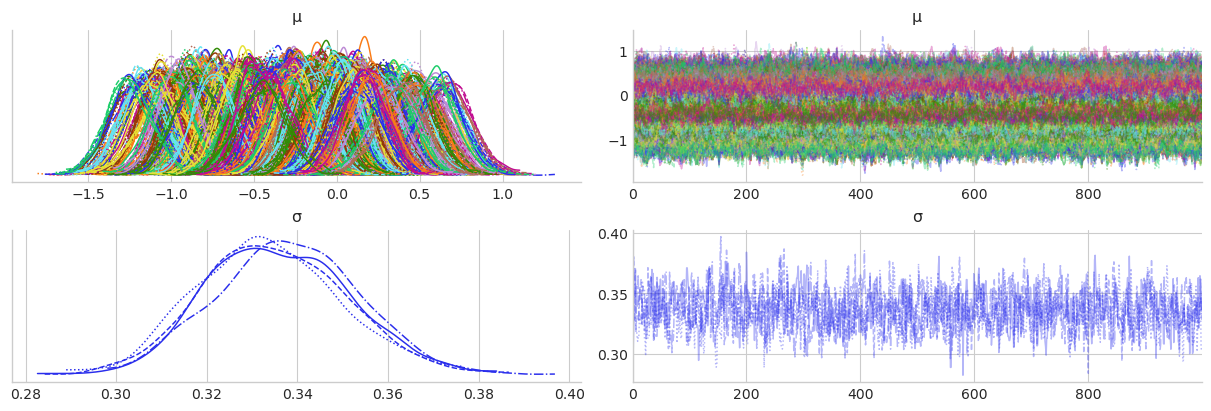

In [54]:
az.plot_trace(idata_1)

<Axes: xlabel='likelihood'>

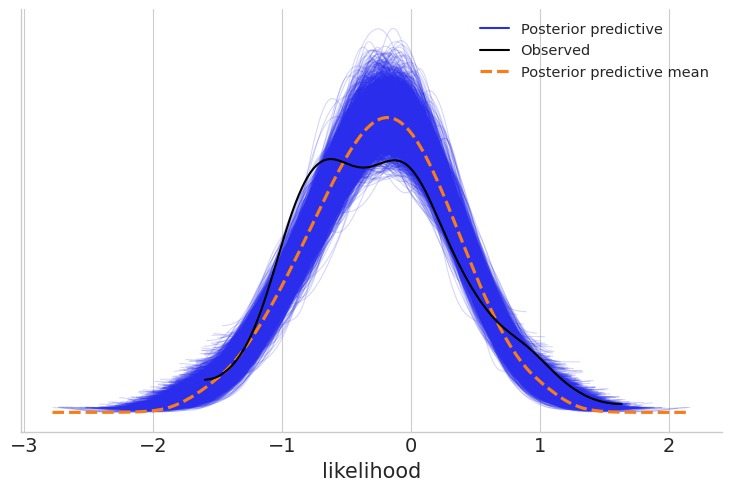

In [55]:
az.plot_ppc(idata_1)

In [73]:
az.summary(idata_1).r_hat.value_counts()

r_hat
1.00    213
1.01    208
1.02      4
Name: count, dtype: int64

### Aφ Model:

In [57]:
df_aph = pd.read_parquet(data_dir / 'df_aph.pqt')

In [58]:
df_aph_ = pd.merge(df_in, df_aph, left_index=True, right_index=True)

In [59]:
df_aph_.dropna(inplace=True)

In [60]:
df_aph_.head()

,Rrc_412,Rrc_443,Rrc_490,Rrc_510,Rrc_555,Rrc_670,ad443,ad555,ad670,ap443,ap555,ap670,aph443,aph555,aph670
2,0.004443,0.004387,0.004240,0.003686,0.002646,0.001177,0.00476,0.00136,0.00037,0.03554,0.00521,0.01077,0.03078,0.00385,0.01040
3,0.005869,0.005866,0.005535,0.004643,0.003326,0.001747,0.00371,0.00082,0.00017,0.02654,0.00392,0.00952,0.02283,0.00310,0.00935
26,0.011926,0.010478,0.007397,0.004815,0.003104,0.001721,0.00090,0.00032,0.00011,0.00346,0.00063,0.00067,0.00256,0.00031,0.00056
31,0.005633,0.006515,0.007241,0.007763,0.009189,0.005709,0.15725,0.04551,0.01274,0.69727,0.10845,0.36724,0.54002,0.06294,0.35450
32,0.007095,0.007713,0.008722,0.009292,0.011147,0.005609,0.14062,0.03998,0.01099,0.21861,0.04894,0.05216,0.07799,0.00896,0.04117


In [62]:
df_aph_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, 2 to 494
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Rrc_412  165 non-null    float64
 1   Rrc_443  165 non-null    float64
 2   Rrc_490  165 non-null    float64
 3   Rrc_510  165 non-null    float64
 4   Rrc_555  165 non-null    float64
 5   Rrc_670  165 non-null    float64
 6   ad443    165 non-null    float64
 7   ad555    165 non-null    float64
 8   ad670    165 non-null    float64
 9   ap443    165 non-null    float64
 10  ap555    165 non-null    float64
 11  ap670    165 non-null    float64
 12  aph443   165 non-null    float64
 13  aph555   165 non-null    float64
 14  aph670   165 non-null    float64
dtypes: float64(15)
memory usage: 20.6 KB


In [80]:
X_aph = df_aph_.filter(regex='Rrc_')
Y_aph = np.log10(df_aph_['aph443'])

In [81]:
X_aph.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, 2 to 494
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Rrc_412  165 non-null    float64
 1   Rrc_443  165 non-null    float64
 2   Rrc_490  165 non-null    float64
 3   Rrc_510  165 non-null    float64
 4   Rrc_555  165 non-null    float64
 5   Rrc_670  165 non-null    float64
dtypes: float64(6)
memory usage: 9.0 KB


<Axes: xlabel='aph443', ylabel='Density'>

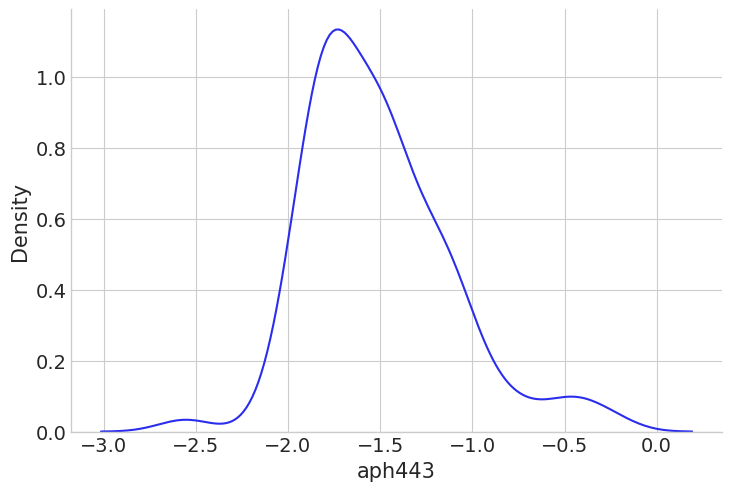

In [82]:
sb.kdeplot(Y_aph)

In [96]:
with pm.Model() as m_aph_1:
    σ = pm.Exponential('σ', 1)
    μ = pmb.BART('μ', X=X_aph, Y=Y_aph)
    pm.Normal('likelihood', mu=μ, sigma=σ, observed=Y_aph)

In [97]:
with m_aph_1:
    idata_aph = pm.sample_prior_predictive()

Sampling: [likelihood, μ, σ]


(-2.0, -1.0)

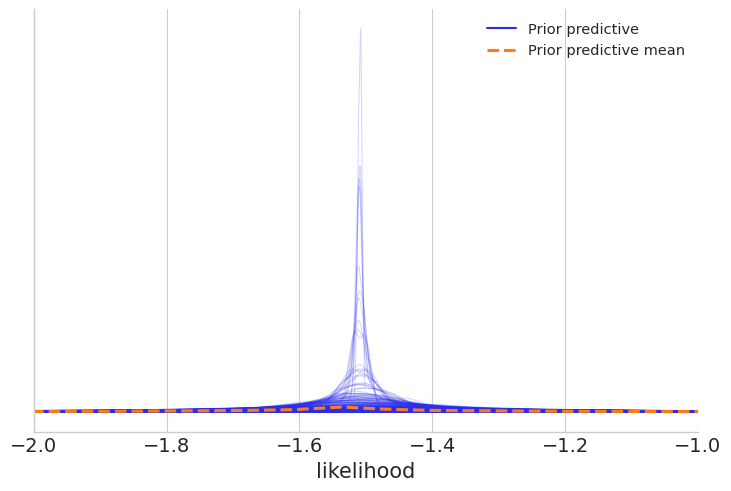

In [98]:
_, ax = pp.subplots()
az.plot_ppc(idata_aph, group='prior', ax=ax)
ax.set_xlim(-2, -1)

In [99]:
with m_aph_1:
    idata_aph.extend(pm.sample(chains=2, draws=4000))
    idata_aph.extend(pm.sample_posterior_predictive(idata_aph))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 57 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

In [100]:
az.summary(idata_aph).r_hat.value_counts()

r_hat
1.01    43
1.02    32
1.03    25
1.05    14
1.04    13
1.06    11
1.00     7
1.08     6
1.07     5
1.10     3
1.11     2
1.09     2
1.13     1
1.18     1
1.14     1
Name: count, dtype: int64

<Axes: xlabel='likelihood'>

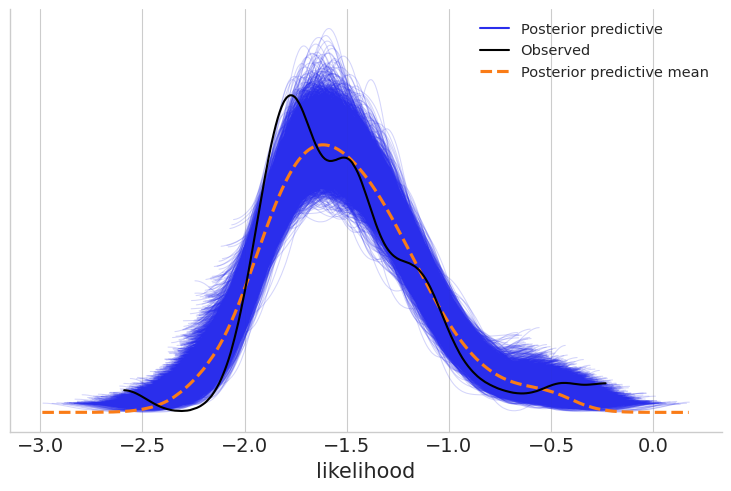

In [101]:
az.plot_ppc(idata_aph)

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_21499/3739498898.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.savefig('./figures/ppc.png', dpi=300)


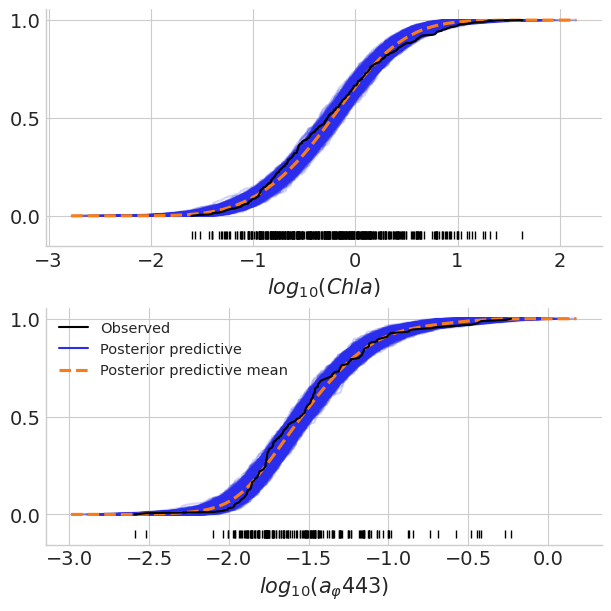

In [111]:
f, axs = pp.subplots(nrows=2, figsize=(6, 6))
az.plot_ppc(idata_1, kind='cumulative', observed_rug=True, ax=axs[0])
az.plot_ppc(idata_aph, kind='cumulative', observed_rug=True, ax=axs[1])
axs[0].set_xlabel(r'$log_{10}(Chl a)$')
axs[0].legend('')
axs[1].set_xlabel(r'$log_{10}(a_φ443)$')
f.savefig('./figures/ppc.png', dpi=300)
f.savefig('./figures/ppc.pdf', dpi=300)

In [ ]:
y_hat_94 = az.hdi(idata_aph.posterior_predictive.likelihood).likelihood.to_numpy()
y_hat_63 = az.hdi(idata_aph.posterior_predictive.likelihood, hdi_prob=0.63).likelihood.to_numpy()

In [119]:
y = idata_aph.observed_data.likelihood.to_numpy()

In [126]:
y.size

165

In [127]:
x = np.arange(y.size)

In [135]:
idx = np.argsort(y)

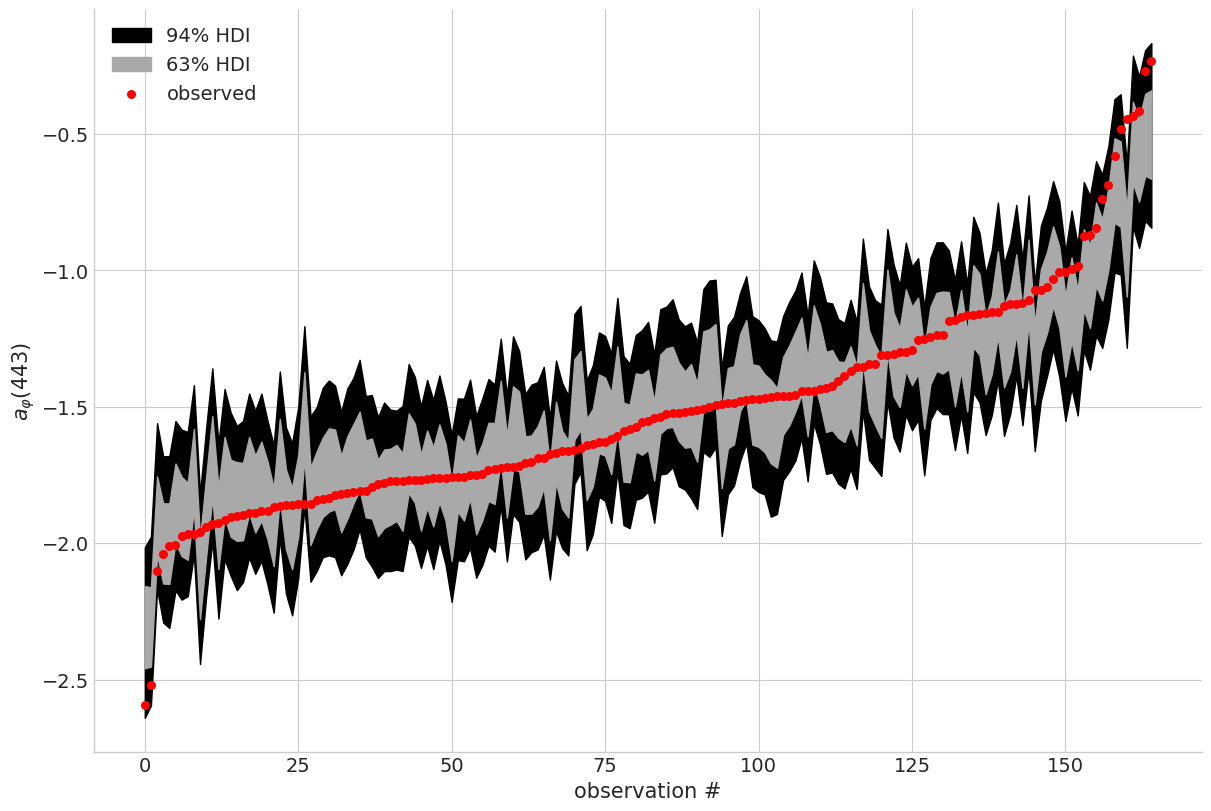

In [137]:

f, ax = pp.subplots(figsize=(12, 8))
ax.fill_between(x=x, y1 = y_hat_94[idx, 0], y2=y_hat_94[idx, 1], color='black', label='94% HDI')
ax.fill_between(x=x, y1=y_hat_63[idx, 0], y2=y_hat_63[idx, 1 ], color='darkgray', label='63% HDI')
ax.scatter(x, y[idx], s=30, color='red', label='observed')
ax.legend()
ax.set_xlabel('observation #')
ax.set_ylabel(r'$a_φ(443)$')
f.savefig('./figures/hdi.png', dpi=300)
f.savefig('./figures/hdi.pdf', dpi=300)


In [117]:
y_hat

<xarray.Dataset> Size: 4kB
Dimensions:           (likelihood_dim_0: 165, hdi: 2)
Coordinates:
  * likelihood_dim_0  (likelihood_dim_0) int64 1kB 0 1 2 3 4 ... 161 162 163 164
  * hdi               (hdi) <U6 48B 'lower' 'higher'
Data variables:
    likelihood        (likelihood_dim_0, hdi) float64 3kB -1.875 ... -0.8485

In [ ]:
pp.fill_between(x = np.array())

<function matplotlib.pyplot.fill(*args, data=None, **kwargs) -> 'list[Polygon]'>